QUESTION 1

In [ ]:
# Install required packages
!pip install torch torchvision

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


100%|██████████| 9.91M/9.91M [00:05<00:00, 1.71MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 97.7kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 884kB/s] 
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Sample training images:


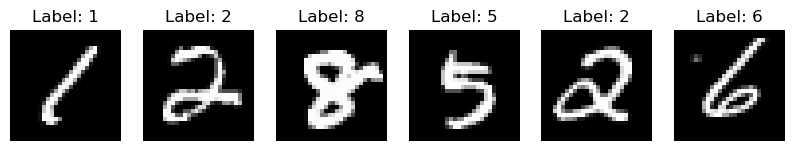

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load training data
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

# Download and load test data
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Function to visualize samples
def visualize_samples(loader, num_samples=6):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    fig = plt.figure(figsize=(10, 4))
    for idx in range(num_samples):
        ax = fig.add_subplot(1, num_samples, idx+1)
        ax.imshow(images[idx].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')
    plt.show()

# Visualize some training samples
print("Sample training images:")
visualize_samples(train_loader)

A. Multi-Layer Perceptron (MLP) Implementation

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize MLP model
mlp_model = MLP().to(device)
print("MLP Model Architecture:")
print(mlp_model)

MLP Model Architecture:
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [7]:
# Define loss function and optimizer
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Evaluation function (will be used for both MLP and CNN)
def evaluate(model, criterion, test_loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100 * correct / total
    return test_loss, test_acc

In [9]:
# Training function for MLP
def train_mlp(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Calculate training loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Evaluate on test set
        test_loss, test_acc = evaluate(model, criterion, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Accuracy: {test_acc:.2f}%")

    return train_losses, test_losses, test_accuracies

# Train MLP model
print("\nTraining MLP...")
mlp_train_losses, mlp_test_losses, mlp_test_accuracies = train_mlp(
    mlp_model, mlp_optimizer, mlp_criterion, train_loader, test_loader, epochs=10
)


Training MLP...
Epoch [1/10], Train Loss: 0.2335, Test Loss: 0.1043, Test Accuracy: 96.57%
Epoch [2/10], Train Loss: 0.1132, Test Loss: 0.0893, Test Accuracy: 97.28%
Epoch [3/10], Train Loss: 0.0893, Test Loss: 0.0837, Test Accuracy: 97.27%
Epoch [4/10], Train Loss: 0.0737, Test Loss: 0.0673, Test Accuracy: 97.87%
Epoch [5/10], Train Loss: 0.0621, Test Loss: 0.0745, Test Accuracy: 97.60%
Epoch [6/10], Train Loss: 0.0564, Test Loss: 0.0813, Test Accuracy: 97.75%
Epoch [7/10], Train Loss: 0.0503, Test Loss: 0.0686, Test Accuracy: 98.10%
Epoch [8/10], Train Loss: 0.0475, Test Loss: 0.0847, Test Accuracy: 97.62%
Epoch [9/10], Train Loss: 0.0438, Test Loss: 0.0754, Test Accuracy: 98.08%
Epoch [10/10], Train Loss: 0.0398, Test Loss: 0.0724, Test Accuracy: 98.13%


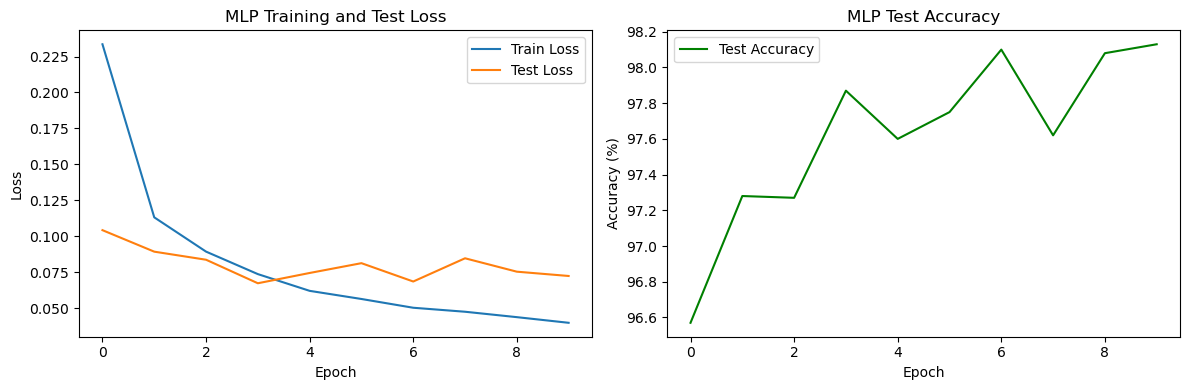


Final MLP Test Accuracy: 98.13%


In [11]:
# Plot MLP training results
plt.figure(figsize=(12, 4))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(mlp_train_losses, label='Train Loss')
plt.plot(mlp_test_losses, label='Test Loss')
plt.title('MLP Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(mlp_test_accuracies, label='Test Accuracy', color='green')
plt.title('MLP Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation
final_test_loss, final_test_acc = evaluate(mlp_model, mlp_criterion, test_loader)
print(f"\nFinal MLP Test Accuracy: {final_test_acc:.2f}%")

B. Convolutional Neural Network (CNN) Implementation

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # 28x28x32
        x = self.pool(x)              # 14x14x32
        x = self.relu(self.conv2(x))  # 14x14x64
        x = self.pool(x)              # 7x7x64
        x = x.view(-1, 64*7*7)        # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize CNN model
cnn_model = CNN().to(device)
print("CNN Model Architecture:")
print(cnn_model)

CNN Model Architecture:
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [15]:
# Define loss function and optimizer for CNN
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [17]:
# Training function for CNN
def train_cnn(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Calculate training loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Evaluate on test set
        test_loss, test_acc = evaluate(model, criterion, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Accuracy: {test_acc:.2f}%")

    return train_losses, test_losses, test_accuracies

# Train CNN model
print("\nTraining CNN...")
cnn_train_losses, cnn_test_losses, cnn_test_accuracies = train_cnn(
    cnn_model, cnn_optimizer, cnn_criterion, train_loader, test_loader, epochs=10
)


Training CNN...
Epoch [1/10], Train Loss: 0.1508, Test Loss: 0.0423, Test Accuracy: 98.62%
Epoch [2/10], Train Loss: 0.0517, Test Loss: 0.0369, Test Accuracy: 98.89%
Epoch [3/10], Train Loss: 0.0371, Test Loss: 0.0312, Test Accuracy: 99.02%
Epoch [4/10], Train Loss: 0.0285, Test Loss: 0.0315, Test Accuracy: 99.00%
Epoch [5/10], Train Loss: 0.0242, Test Loss: 0.0230, Test Accuracy: 99.28%
Epoch [6/10], Train Loss: 0.0191, Test Loss: 0.0259, Test Accuracy: 99.31%
Epoch [7/10], Train Loss: 0.0168, Test Loss: 0.0291, Test Accuracy: 99.23%
Epoch [8/10], Train Loss: 0.0150, Test Loss: 0.0396, Test Accuracy: 98.97%
Epoch [9/10], Train Loss: 0.0131, Test Loss: 0.0271, Test Accuracy: 99.32%
Epoch [10/10], Train Loss: 0.0133, Test Loss: 0.0308, Test Accuracy: 99.19%


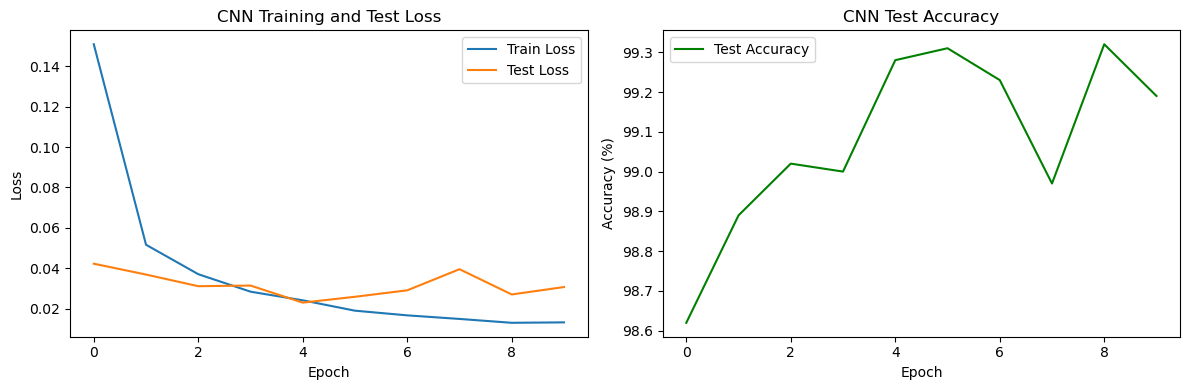


Final CNN Test Accuracy: 99.19%


In [19]:
# Plot CNN training results
plt.figure(figsize=(12, 4))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_test_losses, label='Test Loss')
plt.title('CNN Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_test_accuracies, label='Test Accuracy', color='green')
plt.title('CNN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation
final_test_loss, final_test_acc = evaluate(cnn_model, cnn_criterion, test_loader)
print(f"\nFinal CNN Test Accuracy: {final_test_acc:.2f}%")

Comparison of MLP and CNN

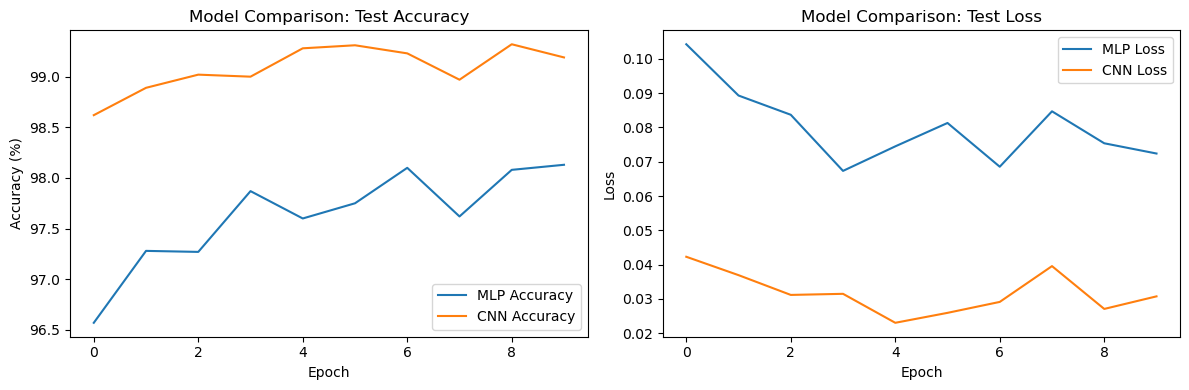

In [21]:
# Compare MLP and CNN performance
plt.figure(figsize=(12, 4))

# Compare test accuracy
plt.subplot(1, 2, 1)
plt.plot(mlp_test_accuracies, label='MLP Accuracy')
plt.plot(cnn_test_accuracies, label='CNN Accuracy')
plt.title('Model Comparison: Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Compare test loss
plt.subplot(1, 2, 2)
plt.plot(mlp_test_losses, label='MLP Loss')
plt.plot(cnn_test_losses, label='CNN Loss')
plt.title('Model Comparison: Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()